# Exp1: NB vs SVM #

Summary: 

It seems a linear Support Vector Machine performs better then Naive Bayes for all targets except Climate Change. However, notice the variation is scores over folds (SD), which makes comparison largely meaning less. Largely depends on the setting of C. Basically with increase of C, mean score goes up, but SD increases (overfitting).

(Trying some variations in parameter setting for vectorizer or classifiers - not shown here - do not seem to improve scores)

In [61]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [19]:
data = pd.read_csv(open('semeval2016-task6-trainingdata.txt'), '\t', index_col=0)

In [20]:
targets = list(data.Target.unique()) + ['All']

In [159]:
classifiers = [MultinomialNB(), 
               LinearSVC(C=0.0001),
               SVC(C=100), 
               LogisticRegression(C=0.01,
                                  #solver='lbfgs',
                                  #multi_class='multinomial',
                                  class_weight='balanced'),
               SGDClassifier(n_iter=50, class_weight='balanced')]

In [137]:
clf_names = [str(c).split('(')[0] for c in classifiers]

dtype = [(name, 'f') for name in clf_names]

means = pd.DataFrame(np.zeros(len(targets), dtype=dtype), 
                     index=targets)

errors = pd.DataFrame(np.zeros(len(targets), dtype=dtype), 
                      index=targets)

In [62]:
macro_f_scorer = make_scorer(fbeta_score,
                             beta=1.0,
                             labels=['AGAINST', 'FAVOR'],
                             average='macro')

In [160]:
for target in targets:
    print 80 * "="
    print target
    print 80 * "="

    target_data = data[data.Target == target] if target != 'All' else data

    cv = StratifiedKFold(target_data.Stance, n_folds=5, shuffle=True,
                         random_state=13)
    for clf in classifiers:
        print clf, '\n'
        pipeline = Pipeline([('vect', CountVectorizer(decode_error='ignore')),
                             ('clf', clf)])
        
        #pred_stances = cross_val_predict(pipeline, target_data.Tweet,
        #                                 target_data.Stance, cv=cv)
        scores = cross_val_score(pipeline, target_data.Tweet, target_data.Stance, scoring=macro_f_scorer, cv=cv)
        print scores
        print 'macro-average of F-score(FAVOR) and F-score(AGAINST): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2)
        print
        
        #print classification_report(target_data.Stance, pred_stances, digits=4)

        #macro_f = fbeta_score(target_data.Stance, pred_stances, 1.0,
        #                      labels=['AGAINST', 'FAVOR'], average='macro')
        #print 'macro-average of F-score(FAVOR) and F-score(AGAINST): {:.4f}\n'.format(macro_f)
        
        clf_name = str(clf).split('(')[0]
        means.at[target, clf_name] = scores.mean()
        errors.at[target, clf_name] = 2 * scores.std()

Atheism
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) 

[ 0.59354839  0.46583851  0.56401766  0.55855856  0.5230303 ]
macro-average of F-score(FAVOR) and F-score(AGAINST): 0.54 (+/- 0.09)

LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 

[ 0.36969697  0.36969697  0.37423313  0.37423313  0.37267081]
macro-average of F-score(FAVOR) and F-score(AGAINST): 0.37 (+/- 0.00)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

[ 0.62580645  0.50699301  0.60974178  0.53333333  0.59413068]
macro-average of F-score(FAVOR) and F-score(AGAINST): 0.57 (+/- 0.09)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercep

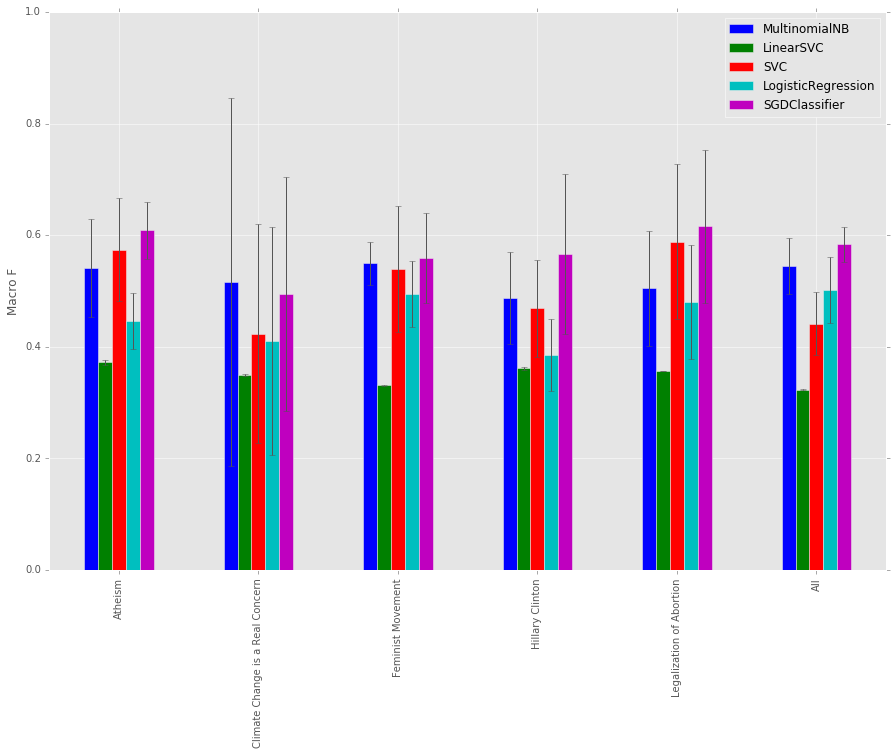

In [163]:
fig, ax = plt.subplots()
fig.set_size_inches((15,10))
means.columns = clf_names
errors.columns = clf_names
ax.set_ylim([0,1.0])
ax.set_ylabel('Macro F')
means.plot(yerr=errors, ax=ax, kind='bar')